In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.neighbors import NearestNeighbors

In [46]:
def df_fix(df, is_train):
    df = df.fillna(-1)

    df[['Group', 'Num_in_group']] = df['PassengerId'].str.split('_', expand=True)
    df['Group'] = df['Group'].astype(int)
    df['Num_in_group'] = df['Num_in_group'].astype(int)

    df['CryoSleep'] = df['CryoSleep'].astype(int)
    if is_train:
        df['Transported'] = df['Transported'].astype(int)

    df.loc[df['HomePlanet'] == 'Europa', 'HomePlanet'] = 1
    df.loc[df['HomePlanet'] == 'Earth', 'HomePlanet'] = 2
    df.loc[df['HomePlanet'] == 'Mars', 'HomePlanet'] = 3

    
    df[['deck', 'num', 'side']] = df['Cabin'].str.split('/', expand=True)

    df = df.fillna(-1)
    df = df.drop(['Cabin'], axis=1)

    df[['Naame', 'Last_name']] = df['Name'].str.split(' ', expand=True)
    df = df.drop(['Name'], axis=1)
    df = df.rename(columns={'Naame': 'Name'})


    df['VIP'] = df['VIP'].astype(int)

    df.loc[df['Destination'] == 'TRAPPIST-1e', 'Destination'] = 1
    df.loc[df['Destination'] == 'PSO J318.5-22', 'Destination'] = 2
    df.loc[df['Destination'] == '55 Cancri e', 'Destination'] = 3
    df['Destination'] = df['Destination'].astype(int)

    df.loc[df['deck'] == 'A', 'deck'] = 1
    df.loc[df['deck'] == 'B', 'deck'] = 2
    df.loc[df['deck'] == 'C', 'deck'] = 3
    df.loc[df['deck'] == 'D', 'deck'] = 4
    df.loc[df['deck'] == 'E', 'deck'] = 5
    df.loc[df['deck'] == 'F', 'deck'] = 6
    df.loc[df['deck'] == 'G', 'deck'] = 7
    df.loc[df['deck'] == 'T', 'deck'] = 8
    df['deck'] = df['deck']

    df.loc[df['side'] == 'P', 'side'] = 1
    df.loc[df['side'] == 'S', 'side'] = 2
    df['side'] = df['side']

    df['deck'] = df['deck'].astype(int)
    df['num'] = df['num'].astype(int)
    df['side'] = df['side'].astype(int)

    if is_train:
        df = df[['PassengerId', 'Transported', 'Group', 'Num_in_group', 'HomePlanet', 'CryoSleep', 'deck', 'num', 'side', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Last_name']]
    else:
        df = df[['PassengerId', 'Group', 'Num_in_group', 'HomePlanet', 'CryoSleep', 'deck', 'num', 'side', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Last_name']]


    return df

In [47]:
train = pd.read_csv('C:\\Users\\Admin\\Desktop\\AIM 2сем\\kaggle\\Spaceship Titanic\\data\\train.csv')
test = pd.read_csv('C:\\Users\\Admin\\Desktop\\AIM 2сем\\kaggle\\Spaceship Titanic\\data\\test.csv')

train = df_fix(train, True)
test = df_fix(test, False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_186304\1601902210.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(-1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_186304\1601902210.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(-1)


In [48]:
def add_knn(X, cols, cat, num, k, radius):
    neigh = NearestNeighbors(n_neighbors=k, radius=radius)
    neigh.fit(X[cols])

    dist, ind = neigh.kneighbors(X[cols])

    X['dist_mean'] = dist[:, 1:].mean(axis=1)
    X['dist_min'] = dist[:, 1:].min(axis=1)
    X['dist_max'] = dist[:, 1:].max(axis=1)
    X['dist_std'] = dist[:, 1:].std(axis=1)

    for c in cat:
        X[f'knn_{c}_mode'] = None
        X[f'knn_{c}_invalid_count'] = 0

    for n in num:
        X[f'knn_{c}_mean'] = -1
        X[f'knn_{c}_max'] = -1
        X[f'knn_{c}_min'] = -1
        X[f'knn_{c}_std'] = -1
        X[f'knn_{c}_invalid_count'] = 0

    for i, row in enumerate(ind):
        neighbors = X.iloc[row[1:]]
        
        for c in cat:
            inval_count = (neighbors[c] == -1).count()
            X.at[X.index[i], f'knn_{c}_invalid_count'] = inval_count

            val_values = neighbors[neighbors[c] != -1][c]
            if not val_values.empty:
                X.at[X.index[i], f'knn_{c}_mode'] = val_values.mode()[0]
        
        for n in num:
            inval_count = (neighbors[n] == -1).count()
            X.at[X.index[i], f'knn_{n}_invalid_count'] = inval_count

            val_values = neighbors[neighbors[n] != -1][n]
            if not val_values.empty:
                X.at[X.index[i], f'knn_{n}_mean'] = val_values.mean()
                X.at[X.index[i], f'knn_{n}_max'] = val_values.max()
                X.at[X.index[i], f'knn_{n}min'] = val_values.min()
                X.at[X.index[i], f'knn_{n}std'] = val_values.std()


        X['knn_HomePlanet_mode'] = X['knn_HomePlanet_mode'].fillna(-1).astype(int)
        X['knn_side_mode'] = X['knn_side_mode'].fillna(-1).astype(int)
        X['knn_Group_mode'] = X['knn_Group_mode'].fillna(-1).astype(int)
        X['knn_deck_mode'] = X['knn_deck_mode'].fillna(-1).astype(int)
        X['knn_VIP_mode'] = X['knn_VIP_mode'].fillna(-1).astype(int)
        X['knn_Destination_mode'] = X['knn_Destination_mode'].fillna(-1).astype(int)
        X['knn_Num_in_group_mode'] = X['knn_Num_in_group_mode'].fillna(-1).astype(int)

    return X

In [49]:
cat = ['Group', 'Num_in_group', 'HomePlanet', 'deck', 'side', 'Destination', 'VIP']
num = ['CryoSleep', 'num', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

knn_cols = list(set(train.columns) - set(['Transported', 'PassengerId', 'Name', 'Last_name']))

#train = add_knn(train, knn_cols, cat, num, k=10, radius=2)
#test = add_knn(test, knn_cols, cat, num, k=10, radius=2)

In [50]:
#lgb
from sklearn.model_selection import train_test_split

def lgb_train(train, params, cols, is_val):
    if is_val:
        X_train, X_test, Y_train, Y_test = train_test_split(train[cols], train.Transported, test_size=0.3, random_state=42)

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train,Y_train,eval_set=[(X_test,Y_test),(X_train,Y_train)], eval_metric='logloss')

    else:
        X_train = train[cols]
        Y_train = train.Transported

        model = lgb.LGBMClassifier(**params)
        model.fit(X_train,Y_train)

    return model

In [51]:
params = {
    'objective': 'binary',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'verbosity': 1  # Отключить логи
}

cols = list(set(train.columns) - set(['Transported', 'PassengerId', 'Name', 'Last_name']))

filtered_list = [item for item in cols if not item.startswith("knn_")]

lgb_model = lgb_train(train, params, cols, is_val=False)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1904
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


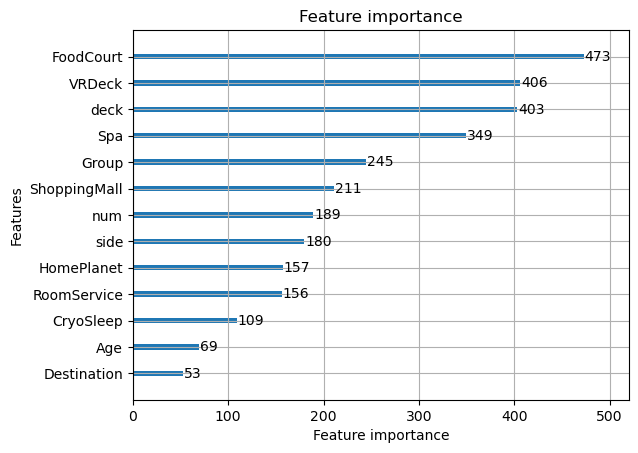

In [52]:
lgb.plot_importance(lgb_model, importance_type='split', max_num_features=20)
plt.show()

In [53]:
test['Transported'] = lgb_model.predict(test[cols])
test.loc[test['Transported'] == 1, 'Transported'] = 'True'
test.loc[test['Transported'] == 0, 'Transported'] = 'False'
test[['PassengerId', 'Transported']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_186304\2868895306.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  test.loc[test['Transported'] == 1, 'Transported'] = 'True'


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [54]:
test[['PassengerId', 'Transported']].to_csv('sub.csv', index=False)

In [55]:
train 

,PassengerId,Transported,Group,Num_in_group,HomePlanet,CryoSleep,deck,num,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Last_name
0,0001_01,0,1,1,1,0,2,0,1,1,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham,Ofracculy
1,0002_01,1,2,1,2,0,6,0,2,1,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna,Vines
2,0003_01,0,3,1,1,0,1,0,2,1,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark,Susent
3,0003_02,0,3,2,1,0,1,0,2,1,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam,Susent
4,0004_01,1,4,1,2,0,6,1,2,1,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,9276,1,1,0,1,98,1,3,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior,Noxnuther
8689,9278_01,0,9278,1,2,1,7,1499,2,2,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta,Mondalley
8690,9279_01,1,9279,1,2,0,7,1500,2,1,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey,Connon
8691,9280_01,0,9280,1,1,0,5,608,2,3,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon,Hontichre
